In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [2]:
%matplotlib inline

In [31]:
def mostrar_imagenes(image_array, num_images=25, size=(28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_plot = image_array.reshape(-1, *size)
#     plt.figure(figsize=(15, 4.5))
    for i in range(num_images):
        plt.subplot(5, int(num_images) / 5, i + 1)
        plt.imshow(image_plot[i].astype(np.uint8), cmap=plt.cm.binary)
        plt.axis('off')
    plt.show()

In [3]:
def obtener_bloque_generador(dim_entrada: int, dim_salida: int) -> tf.keras.Model:
    ''' Genera una capa lineal con normalización por bloques '''
    entrada = tf.keras.Input(shape=dim_entrada)
    capa_lineal = tf.keras.layers.Dense(units=dim_salida)(entrada)
    normalizacion = tf.keras.layers.BatchNormalization()(capa_lineal)
    salida_relu = tf.keras.activations.relu(normalizacion)
    return tf.keras.Model(inputs=entrada, outputs=salida_relu)

def obtener_generador(dim_z: int = 10, dim_imagen: int = 784, dim_oculta: int = 128) -> tf.keras.Model:
    ''' Generador de imágenes '''
    entrada = tf.keras.Input(shape=dim_z)
    salida_1 = obtener_bloque_generador(dim_entrada=dim_z, dim_salida=dim_oculta)(entrada)
    salida_2 = obtener_bloque_generador(dim_entrada=dim_oculta, dim_salida=dim_oculta*2)(salida_1)
    salida_3 = obtener_bloque_generador(dim_entrada=dim_oculta*2, dim_salida=dim_oculta*4)(salida_2)
    salida_4 = obtener_bloque_generador(dim_entrada=dim_oculta*4, dim_salida=dim_oculta*8)(salida_3)
    salida_lineal = tf.keras.layers.Dense(units=dim_imagen)(salida_4)
    salida_sigmoide = tf.keras.activations.sigmoid(salida_lineal)
    return tf.keras.Model(inputs=entrada, outputs=salida_sigmoide)

In [4]:
obtener_generador().summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
model (Functional)           (None, 128)               1920      
_________________________________________________________________
model_1 (Functional)         (None, 256)               34048     
_________________________________________________________________
model_2 (Functional)         (None, 512)               133632    
_________________________________________________________________
model_3 (Functional)         (None, 1024)              529408    
_________________________________________________________________
dense_4 (Dense)              (None, 784)               803600    
_________________________________________________________________
tf.math.sigmoid (TFOpLambda) (None, 784)               0   

In [5]:
def obtener_ruido(numero_muestra: int, dim_z: int) -> tf.random.normal:
    ''' Genera vector aleatorios de dimension (numero_muestra, dim_z) '''
    return tf.random.normal((numero_muestra, dim_z))

In [6]:
obtener_ruido(2, 10)

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[ 0.3329163 , -1.513184  , -0.17042692, -0.82294095,  0.92231166,
        -0.00937828,  1.5929273 , -1.1269627 ,  0.20039932, -0.13571087],
       [-0.17926964, -0.12734522, -0.63657004, -0.7991805 ,  0.82898897,
         0.05738529,  0.91351885,  0.4058572 ,  0.6958022 , -1.1581689 ]],
      dtype=float32)>

In [7]:
def obtener_bloque_discriminador(dim_entrada: int, dim_salida: int) -> tf.keras.Model:
    ''' Genera una capa lineal con normalización por bloques '''
    entrada = tf.keras.Input(shape=dim_entrada)
    capa_lineal = tf.keras.layers.Dense(units=dim_salida)(entrada)
    salida_leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
    return tf.keras.Model(inputs=entrada, outputs=salida_leaky_relu)

def obtener_discriminador(dim_imagen: int = 784, dim_oculta: int = 128) -> tf.keras.Model:
    ''' Generador de imágenes '''
    entrada = tf.keras.Input(shape=dim_imagen)
    salida_1 = obtener_bloque_generador(dim_entrada=dim_imagen, dim_salida=dim_oculta*4)(entrada)
    salida_2 = obtener_bloque_generador(dim_entrada=dim_oculta*4, dim_salida=dim_oculta*2)(salida_1)
    salida_3 = obtener_bloque_generador(dim_entrada=dim_oculta*2, dim_salida=dim_oculta)(salida_2)
    salida_lineal = tf.keras.layers.Dense(units=1)(salida_3)
    return tf.keras.Model(inputs=entrada, outputs=salida_lineal)

In [8]:
obtener_discriminador().summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
model_5 (Functional)         (None, 512)               403968    
_________________________________________________________________
model_6 (Functional)         (None, 256)               132352    
_________________________________________________________________
model_7 (Functional)         (None, 128)               33408     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 569,857
Trainable params: 568,065
Non-trainable params: 1,792
_________________________________________________________________


In [9]:
def obtener_perdida_discriminador(generador: tf.keras.Model, discriminador: tf.keras.Model, imagenes_real, num_imagenes, dim_z):
    ''' Obtiene perdida del discriminador '''
    rudio = obtener_ruido(numero_muestra=num_imagenes, dim_z=dim_z)
    imagenes_falsa = generador(rudio)
    prediccion_falsa = discriminador(tf.stop_gradient(imagenes_falsa))
    target_falsa = tf.zeros_like(prediccion_falsa)
    perdida_falsa = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=target_falsa, logits=prediccion_falsa))
    
    prediccion_real = discriminador(imagenes_real)
    target_real = tf.ones_like(prediccion_real)
    perdida_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=target_real, logits=prediccion_real))

    perdida_discriminador = (perdida_falsa + perdida_real) / 2
    return perdida_discriminador

In [10]:
def obtener_perdida_generador(generador, discriminador, num_imagenes, dim_z):
    rudio = obtener_ruido(numero_muestra=num_imagenes, dim_z=dim_z)
    imagenes_falsa = generador(rudio)
    prediccion_falsa = discriminador(imagenes_falsa)
    target_falsa = tf.ones_like(prediccion_falsa)
    perdida_generador = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=target_falsa, logits=prediccion_falsa))
    return perdida_generador

In [11]:
def obtener_mnist_data(batch_size=128):
    (mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = tf.keras.datasets.mnist.load_data()
    mnist_x_train = mnist_x_train.reshape(-1, 784)
    mnist_x_test = mnist_x_test.reshape(-1, 784)
    mnist_data = np.concatenate((mnist_x_train, mnist_x_test), axis=0)
    mnist_target = np.concatenate((mnist_y_train, mnist_y_test), axis=0)
    dataset = tf.data.Dataset.from_tensor_slices((mnist_data, mnist_target))
    dataset = dataset.shuffle(len(mnist_data)).batch(batch_size)
    return dataset

In [12]:
dataset = obtener_mnist_data(1024)

In [13]:
generador = obtener_generador(dim_z=64)
generador_optimizador = tf.keras.optimizers.Adam(learning_rate=0.0001)

discriminador = obtener_discriminador()
discriminador_optimizador = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [14]:
dim_z = 64
n_epochs = 200

100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [01:30<00:00,  6.06it/s]


tf.Tensor(0.21673478, shape=(), dtype=float32)
tf.Tensor(10.335106, shape=(), dtype=float32)
tf.Tensor(
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.50899598e-10
  0.00000000e+00  0.00000000e+00 -4.79209381e-11  0.00000000e+00
 -5.26969232e-11  0.00000000e+00  0.00000000e+00 -1.47809126e-10
  0.00000000e+00 -8.36836416e-12  0.00000000e+00 -1.88034727e-11
  0.00000000e+00 -3.19913575e-11 -1.30453270e-11  0.00000000e+00
 -1.51914644e-11  8.01167674e-11 -4.27236614e-11 -3.70832080e-11
 -8.90292614e-12  0.00000000e+00  6.95891608e-11  0.00000000e+00
 -5.04849981e-11  0.00000000e+00  3.53706960e-11  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.64737156e-11 -3.36885138e-11
  1.31023326e-11  4.40478418e-11 -6.65239088e-12  6.22191951e-11
  0.00000000e+00  5.40850593e-11 -7.06256668e-12 -1.17029622e-10
 -2.10243507e-11 -2.15213992e-11 -3.43059019e-11 -2.57696364e-11
  0.00000000e+00  0.00000000e+00  1.38032814e-11  0.00000000e+00
  0.00000000e+00  0.00000000e+00  4.71448922e-11  0

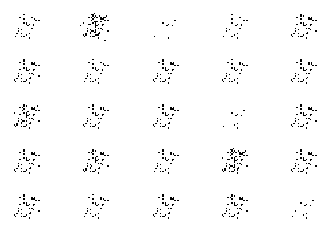

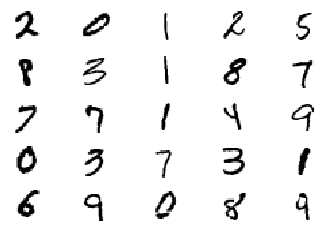

100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:52<00:00, 10.42it/s]


tf.Tensor(0.39315656, shape=(), dtype=float32)
tf.Tensor(21.426962, shape=(), dtype=float32)
tf.Tensor(
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.25493762e-11
  1.45844337e-10 -5.78418875e-11 -9.91069102e-11  0.00000000e+00
 -1.43034213e-11  0.00000000e+00  0.00000000e+00 -1.61119479e-10
  0.00000000e+00 -5.96656405e-12  0.00000000e+00 -9.83492524e-11
  0.00000000e+00 -2.97859896e-11 -3.59553637e-11  0.00000000e+00
 -2.84771998e-11  7.01541394e-11  8.69568133e-12 -7.63716937e-11
 -9.68818706e-11  0.00000000e+00  3.60379174e-12 -5.04587899e-11
  0.00000000e+00  0.00000000e+00  6.90888249e-11  0.00000000e+00
  7.72723344e-11  0.00000000e+00 -3.30872690e-11  4.66050913e-11
  3.24500461e-11 -4.49643864e-11 -5.54900258e-11  7.17530505e-12
  0.00000000e+00 -1.12945807e-11 -1.42718309e-10 -1.27828637e-10
 -8.93173122e-13  0.00000000e+00 -2.21986023e-11 -6.34887490e-11
  0.00000000e+00  0.00000000e+00 -2.40025336e-15  0.00000000e+00
 -2.98103348e-11  0.00000000e+00 -1.14581331e-11  0

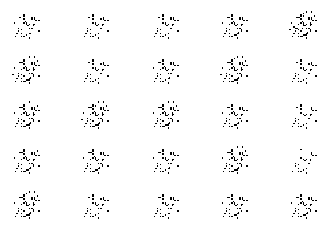

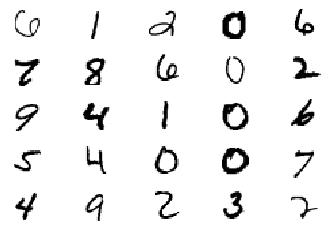

In [44]:
paso_actual = 0
media_perdida_generador = 0
media_perdida_discriminador = 0

for epoch in range(n_epochs):
    
#     for real, _ in dataset:
    for real, _ in tqdm.tqdm(dataset):
        actual_tamanho_batch = len(real)
        
        with tf.GradientTape() as tape:
            perdida_discriminador = obtener_perdida_discriminador(generador, discriminador, real, actual_tamanho_batch, dim_z)
            gradiente_discriminador = tape.gradient(perdida_discriminador, discriminador.trainable_variables)
            discriminador_optimizador.apply_gradients(zip(gradiente_discriminador, discriminador.trainable_variables))
        
        media_perdida_discriminador += perdida_discriminador / actual_tamanho_batch
            
        with tf.GradientTape() as tape:
            perdida_generador = obtener_perdida_generador(generador, discriminador, actual_tamanho_batch, dim_z)
            gradiente_generador = tape.gradient(perdida_generador, generador.trainable_variables)
            generador_optimizador.apply_gradients(zip(gradiente_generador, generador.trainable_variables))
        
        media_perdida_generador += perdida_generador / actual_tamanho_batch
    
    print(media_perdida_discriminador)
    print(media_perdida_generador)
    
#     print(gradiente_discriminador[0][0])
    
    mostrar_imagenes(generador(obtener_ruido(actual_tamanho_batch, dim_z)).numpy(), num_images=25, size=(28, 28))
    mostrar_imagenes(real.numpy(), num_images=25, size=(28, 28))